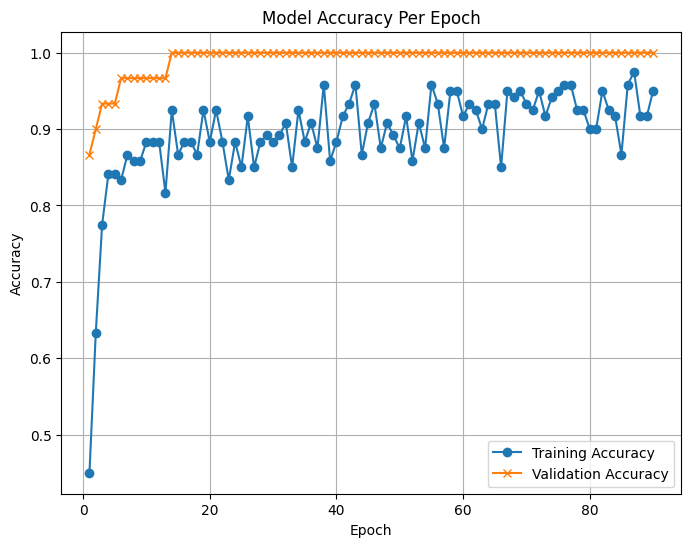

Epoch 90/100, Train Accuracy: 0.9500, Val Accuracy: 1.0000, Val Loss: 0.0587
Early stopping triggered.
Evaluating the model on the test set...
Test Accuracy: 1.0000


In [1]:
# 安裝所需套件
!pip install torch torchvision matplotlib -q

# 匯入必要的庫
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 設定設備 (使用 GPU 如果可用)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加載 Iris 數據集
print("Loading the Iris dataset...")
data = load_iris()
X, y = data.data, data.target
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# 資料標準化
print("Normalizing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 資料分割 (80% 訓練, 20% 測試)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# 將資料轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 建立 DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 定義神經網絡模型
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 初始化模型、損失函數和優化器
model = IrisNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練過程中的即時準確率圖表
train_accuracies = []
val_accuracies = []
epochs_list = []

def plot_accuracies():
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_list, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(epochs_list, val_accuracies, label="Validation Accuracy", marker='x')
    plt.title("Model Accuracy Per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# 訓練模型
print("Training the model...")
epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    # 訓練模式
    model.train()
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # 計算訓練準確率
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # 驗證模式
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # 計算驗證準確率
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # 更新圖表
    epochs_list.append(epoch + 1)
    plot_accuracies()

    # 顯示每個 epoch 的結果
    print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

    # 早停機制
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# 測試模型
print("Evaluating the model on the test set...")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

